# Model comparison

This Notebook's key objective is to compare different models applied on datasets produced with different data imputation strategies.

In [86]:
#importing libraries
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import scale


import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# import custom dependencies
import ADNI_utilities

## Reading and preparing the data

We start by reading all the datasets from different imputation strategies and choosing the response variable to be used. 

The rationale for hyper parameters choices can be found on the "Parameter finetunning" section.

In [87]:
def reverse_one_hot(resp_set, imp_df):
    """This function recreates response variables from one-hot-encoded datasets
    
    # Arguments
        resp_set: contains a list of response variables' prefixes to be rebuilt
        imp_df: contains the imputed dataset with the raw data
    """
    
    col_set = imp_df.columns.tolist()
    is_resp = [any([resp in col for resp in resp_set]) for col in col_set]
    resp_cols = imp_df.columns[is_resp]
    
    # iterate of response prefixes
    resp_data = []
    for resp in resp_set:
    
        # get subset of columns corresponding to currest prefix
        is_subset = [resp in col for col in col_set]
        subset_cols = imp_df.columns[is_subset]
    
        # convert train data to column index of true value
        tmp = np.argmax(imp_df[subset_cols].values,1)+1
        tmp[~imp_df[subset_cols].values.any(1)] = 0
        resp_data.append(tmp)
    
    # drop one-hot response vars and add new features
    imp_df = imp_df.drop(columns=resp_cols, axis=1)
    for col, data in zip(resp_set, resp_data):
        imp_df[col] = pd.Series(np.array(data), index=imp_df.index)
    
    return imp_df

In [88]:
#Initializing the data strucuture that will hold the test scores from different models
classifiers = {}
classifiers['LogisticRegression'] = 'Logistic'
classifiers['KNeighborsClassifier'] = 'kNN'
classifiers['DecisionTreeClassifier'] = 'Decision Tree'
classifiers['BaggingClassifier'] = 'Bagging'
classifiers['AdaBoostClassifier'] = 'Boosting'
classifiers['RandomForestClassifier'] = 'Random Forest'

filenames = {}
filenames['mean - 30pct'] = 'data_mean_upto_30pct_missing.csv'
filenames['mean - 50pct'] = 'data_mean_upto_50pct_missing.csv'
filenames['model - 30pct'] = 'data_modeled_upto_30pct_missing.csv'
filenames['model - 50pct'] = 'data_modeled_upto_50pct_missing.csv'
filenames['model - 100pct'] = 'data_modeled_upto_100pct_missing.csv'
            
result_container_multi = pd.DataFrame(index=list(filenames.keys()), columns=list(classifiers.values()))
result_container_binary = pd.DataFrame(index=list(filenames.keys()), columns=list(classifiers.values()))
estimators = {f_name:[] for f_name in list(filenames.values())}

In [89]:
#Setting up common parameters/config
import warnings
warnings.filterwarnings('ignore')

data_path = '../data/Imputed/'
resp_variable = 'DX_FINAL'
resp_vars = ['DXCOMB', 'DX_CHANGE', 'DX_FINAL', 'DX_BASE', 'DX_bl']
testsize = 0.2
rs = 42 # set random state so results are repeatable
run_binary = 1 #Set this variable to 1 if models with binary response variable are to be run

In [90]:
def train_classifier_cv(estimator, param_grid, cv=5):
    """Trains the given estimator on each design matrix using grid search and
    corss validation. The best estimator and score are saved.
    
    # Argumenrts
        estimator: The estimator/classifier to train/score
        param_grid: the parameters to be used in the grid search
        cv: number of folds to be used for cross validation
    """
    for file_key in list(filenames.keys()):
        #Loading data
        file_nm = filenames[file_key]
        file_w_path = data_path + file_nm
        est_name = estimator.__repr__().split('(')[0]
        
        print(f'{est_name}: fitting {file_w_path}')

        df = pd.read_csv(file_w_path, index_col='RID')
        if 'modeled' in file_nm:
            df = reverse_one_hot(resp_vars, df)
              
        df_train, df_test = train_test_split(df, test_size=testsize, shuffle=True, random_state=rs)

        y_train_multi = df_train[resp_variable]
        if (run_binary == 1 and not 'modeled' in file_nm):
            y_train_bin = df_train[resp_variable].apply(lambda x: 1 if x == 3 else 0)
              
        X_train = df_train.drop(resp_vars, axis=1).select_dtypes(['number'])

        y_test_multi = df_test[resp_variable]
        if (run_binary == 1 and not 'modeled' in file_nm):
            y_test_bin = df_test[resp_variable].apply(lambda x: 1 if x == 3 else 0)
              
        X_test = df_test.drop(resp_vars, axis=1).select_dtypes(['number'])

        #Running the model and storing results

        gs = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=-1,
                          return_train_score=True, iid=False)
        gs.fit(X_train, y_train_multi)
        score = gs.score(X_test, y_test_multi)
        result_container_multi.loc[file_key, classifiers[est_name]] = score
        estimators[file_nm].append((score, gs.best_estimator_))

        if (run_binary == 1 and not 'modeled' in file_nm):
            gs = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=-1,
                              return_train_score=True, iid=False)
            gs.fit(X_train, y_train_bin)
            result_container_binary.loc[file_key, classifiers[est_name]] = gs.score(X_test, y_test_bin)

In [91]:
# kNN
knn = KNeighborsClassifier(n_jobs=-1)
param_grid = {'n_neighbors': [2, 5, 10, 20, 50, 75, 100]}

train_classifier_cv(knn, param_grid)

KNeighborsClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [92]:
# LogisticRegression
logr = LogisticRegression(multi_class="ovr", penalty='l2', max_iter=1000)
logr_params = {'C':10.0 ** np.arange(-4,4)}

train_classifier_cv(logr, logr_params)

LogisticRegression: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [93]:
# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf_params = {'max_depth':[2, 3, 5, 10, 20],
              'min_samples_leaf': [1, 2, 4, 6, 20]}

train_classifier_cv(dt_clf, dt_clf_params)

DecisionTreeClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [94]:
# Bagging
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(dt_clf, n_jobs=-1, n_estimators=100)
bag_clf_params = {'base_estimator__max_depth':[2, 3, 5, 10, 20],
          'base_estimator__min_samples_leaf': [1, 2, 4, 6, 20]}

train_classifier_cv(bag_clf, bag_clf_params)

BaggingClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [95]:
# Boosting
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(dt_clf, n_estimators=100, learning_rate=0.75)
ada_clf_params = {'base_estimator__max_depth':[2, 3, 5, 10, 20],
          'base_estimator__min_samples_leaf': [1, 2, 4, 6, 20]} 

train_classifier_cv(ada_clf, ada_clf_params)

AdaBoostClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [96]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf_params = {'max_depth':[2, 3, 5, 10, 20],
      'min_samples_leaf': [1, 2, 4, 6, 20]}  

train_classifier_cv(rf_clf, rf_clf_params)

RandomForestClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


## Perfomance comparison

This section will present the performance differences across the models tested by our group.

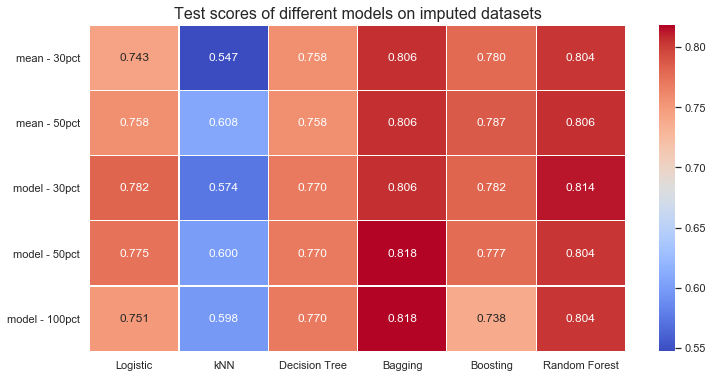

In [97]:
#Plotting the results as a heat map

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax = sns.heatmap(result_container_multi.astype('float64'), annot=True, linewidths=0.1, fmt='.3f', cmap='coolwarm')
ax.set_title('Test scores of different models on imputed datasets', fontsize=16);
plt.show()

In [ ]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [100]:
def get_feature_names(design_mat):
        file_w_path = data_path + design_mat
        df = pd.read_csv(file_w_path, index_col='RID')
        if 'modeled' in design_mat:
            df = reverse_one_hot(resp_vars, df)
              
        df = df.drop(resp_vars, axis=1).select_dtypes(['number'])
        return list(df.columns)

In [101]:
model_path = '../data/Models/Feature_Importance/'
for key in list(estimators.keys()):
    features = get_feature_names(key)
    key_sub = key.split('data_')[1].split('pct')[0]
    for score, model in estimators[key]:
        model_nm = model.__repr__().split('(')[0]
        print(model_nm)
        
        if getattr(model, 'estimators_', False):
            df = pd.DataFrame(columns=features)
            for estimator in model.estimators_:
                df = df.append(pd.Series(estimator.feature_importances_, index=df.columns), ignore_index=True)
            df.to_csv(model_path + f'{model_nm}_{key_sub}.csv')

KNeighborsClassifier
LogisticRegression
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
RandomForestClassifier
KNeighborsClassifier
LogisticRegression
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
RandomForestClassifier
KNeighborsClassifier
LogisticRegression
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
RandomForestClassifier
KNeighborsClassifier
LogisticRegression
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
RandomForestClassifier
KNeighborsClassifier
LogisticRegression
DecisionTreeClassifier
BaggingClassifier
AdaBoostClassifier
RandomForestClassifier


In [63]:
est = estimators['data_mean_upto_30pct_missing.csv'][0][1]
est
est0 = est.estimators_[0]
est.base_estimator.
est0.feature_importances_

SyntaxError: invalid syntax (<ipython-input-63-e249907ff54d>, line 4)

## Dimensionality reduction

We have also explored the possibility of using PCA to reduce the dimensionality of our dataset and reach additional conclusions regarding our dataset and regarding AD diagnosis prediction.

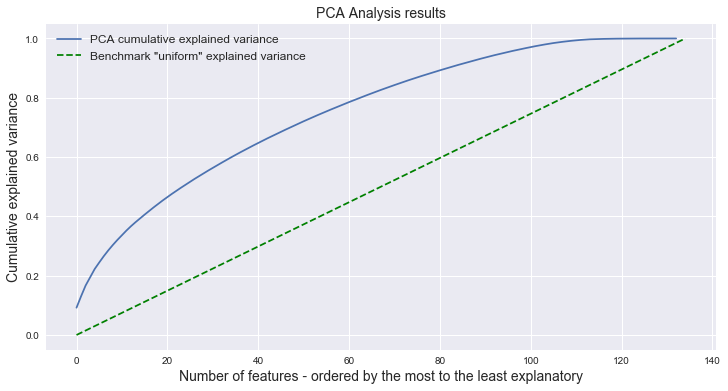

In [64]:
#PCA

#Reading the "strictest" dataset to apply PCA techniques
df = pd.read_csv(data_path + 'data_mean_upto_30pct_missing.csv')

df_train, df_test = train_test_split(df, test_size=testsize, shuffle=True, random_state=rs)
y_train_multi = df_train[resp_variable]
X_train = df_train.drop(resp_vars, axis=1).select_dtypes(['number'])
X_train = scale(X_train)

#y_test_multi = df_test[resp_variable]
#X_test = df_test.drop(resp_vars, axis=1).select_dtypes(['number'])
#X_test = scale(X_test)

#Running the PCA routine
pca = PCA()
pca.fit(X_train)

#Plotting the results
fig, ax = plt.subplots(1,1, figsize=(12,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='PCA cumulative explained variance')
plt.plot(np.linspace(0,1,135), 'g--', label='Benchmark "uniform" explained variance')
plt.legend(fontsize=12)
ax.set_xlabel('Number of features - ordered by the most to the least explanatory', fontsize=14)
ax.set_ylabel('Cumulative explained variance', fontsize=14)
ax.set_title('PCA Analysis results', fontsize=14);

As one can see in the plot above, there is not a strong explanatory power concentration on any principal component. Out of 133 components on the select dataset, more than 80 are needed to achieve 90% variance explanation. The top 20 components explain less than 50% of the variance. It is interesting to notice that, after the 20th and before the 100th component, the blue line is almost "parallel" to the green benchmark line - showing that there is very limited explanatory power concentration.

For this reason, added to the fact that similar results hold for all imputation strategies, we have decided not to use PCA as a tool to further improve our models.

## Parameter tuning

In this section, one will find the reasoning behind the choice of hyperparameters used in each fitted model. We will use the mean-imputed database with 30-pct threshold as the basis for hyperparameter fine-tunning.

In [11]:
df = pd.read_csv('../data/Imputed/data_mean_upto_30pct_missing.csv')

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=rs)
resp_vars = ['DXCOMB', 'DX_CHANGE', 'DX_FINAL', 'DX_BASE', 'DX_bl']

y_train_multi = df_train['DX_FINAL']
y_train_bin = df_train['DX_FINAL'].apply(lambda x: 1 if x == 3 else 0)
X_train = df_train.drop(resp_vars, axis=1).select_dtypes(['number'])

y_test_multi = df_test['DX_FINAL']
y_test_bin = df_test['DX_FINAL'].apply(lambda x: 1 if x == 3 else 0)
X_test = df_test.drop(resp_vars, axis=1).select_dtypes(['number'])

### Logistic classifier

In [12]:
logistic = LogisticRegressionCV(multi_class="ovr", cv=4, penalty='l2').fit(X_train, y_train_multi)
logistic.score(X_test, y_test_multi)

0.7312348668280871

In [13]:
#Repeating the process for the binary response variable
logistic = LogisticRegressionCV(multi_class="ovr", cv=4, penalty='l2').fit(X_train, y_train_bin)
logistic.score(X_test, y_test_bin)

0.8692493946731235

There is no hyper parameter to choose, but training/fit conditions were set.

### kNN

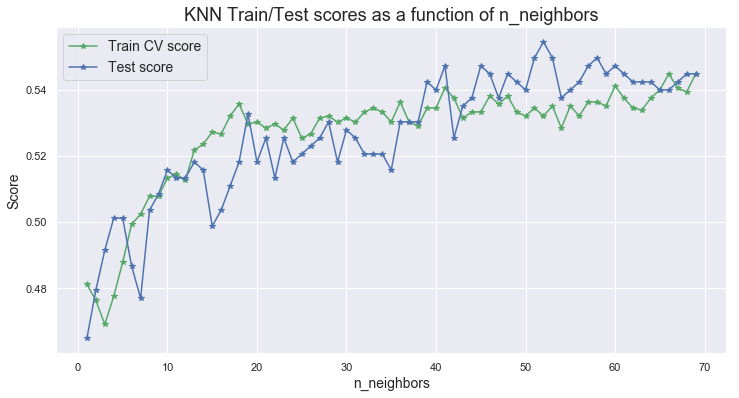

In [39]:
k_set = range(1,70)

scores = []
scores_test = []
for i in k_set:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train_multi)
    scores.append(np.mean(cross_val_score(knn, X_train, y_train_multi, cv=5)))
    scores_test.append(knn.score(X_test, y_test_multi))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(k_set, scores, 'g*-', label = 'Train CV score')
ax.plot(k_set, scores_test, 'b*-', label = 'Test score')
ax.set_xlabel('n_neighbors', size=14)
ax.set_ylabel('Score', size=14)
ax.legend(fontsize=14)
ax.set_title('KNN Train/Test scores as a function of n_neighbors', size=18)

plt.show()

In the kNN models for the multi category response variable, `k=52` appears to be the optimal parameter.

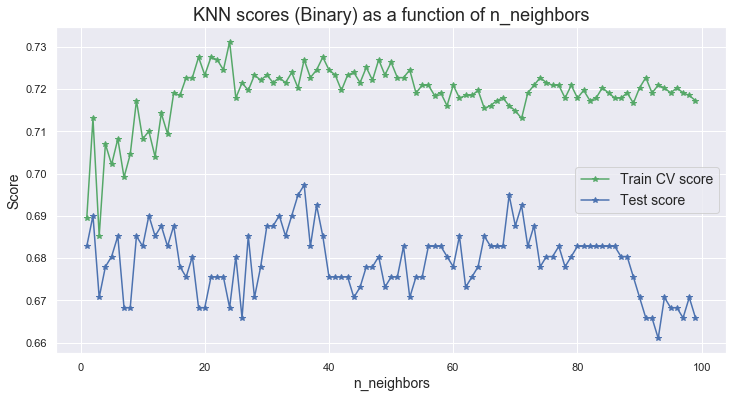

In [40]:
#Repeating the process for the binary response variable
k_set = range(1,100)

scores = []
scores_test = []
for i in k_set:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train_bin)
    scores.append(np.mean(cross_val_score(knn, X_train, y_train_bin, cv=5)))
    scores_test.append(knn.score(X_test, y_test_bin))

fig, ax = plt.subplots(1,1, figsize=(12, 6))
    
ax.plot(k_set, scores, 'g*-', label = 'Train CV score')
ax.plot(k_set, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('n_neighbors', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('KNN scores (Binary) as a function of n_neighbors', size=18)

plt.show()

In the kNN models for the binary response variable, `k=36` appears to be the optimal parameter.

### Simple decision tree

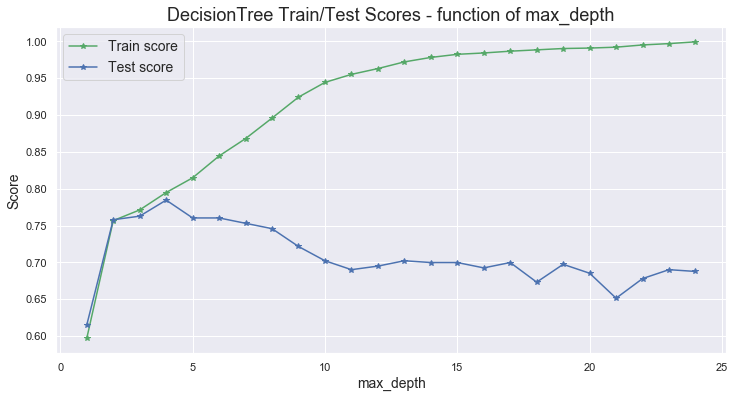

In [16]:
depths = range(1,25)

scores = []
scores_test = []
for i in depths:
    dec = DecisionTreeClassifier(max_depth=i)
    dec.fit(X_train, y_train_multi)
    scores.append(dec.score(X_train, y_train_multi))
    scores_test.append(dec.score(X_test, y_test_multi))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(depths, scores, 'g*-', label = 'Train score')
ax.plot(depths, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('max_depth', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title("DecisionTree Train/Test Scores - function of max_depth", size=18)

plt.show()

Among the Decision Tree models for the multi category response variable, `max_depth=3` appears to be the optimal parameter.

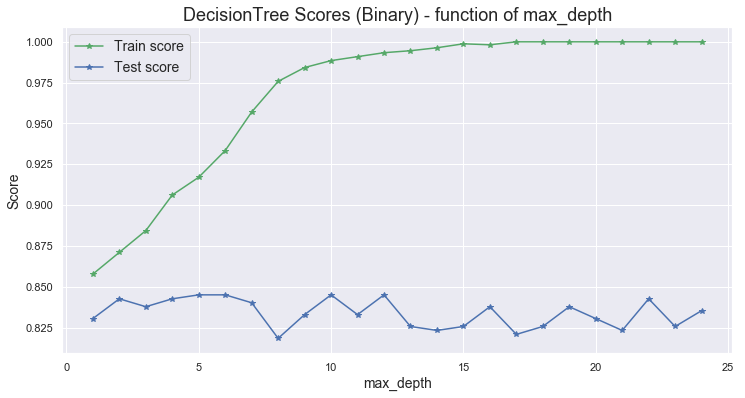

In [17]:
#Repeating the process for the binary decision variable
depths = range(1,25)

scores = []
scores_test = []
for i in depths:
    dec = DecisionTreeClassifier(max_depth=i)
    dec.fit(X_train, y_train_bin)
    scores.append(dec.score(X_train, y_train_bin))
    scores_test.append(dec.score(X_test, y_test_bin))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(depths, scores, 'g*-', label = 'Train score')
ax.plot(depths, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('max_depth', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title("DecisionTree Scores (Binary) - function of max_depth", size=18)

plt.show()

Among the Decision Tree models for the binary response variable, `max_depth=6` appears to be the optimal parameter.

### Bagging decision tree

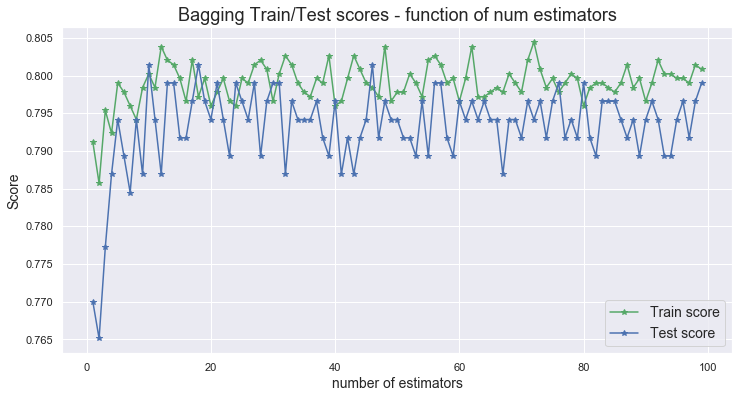

In [36]:
num_trees = range(1,100)

scores = []
scores_test = []
for i in num_trees:
    bag = BaggingClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=i)
    bag.fit(X_train, y_train_multi)
    scores.append(bag.score(X_train, y_train_multi))
    scores_test.append(bag.score(X_test, y_test_multi))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(num_trees, scores, 'g*-', label = 'Train score')
ax.plot(num_trees, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('number of estimators',size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('Bagging Train/Test scores - function of num estimators', size=18)

plt.show()

In [37]:
scores_test.index(max(scores_test))

9

Among the Bagging Decision Trees for the multi category response variable, `n_estimators=13` seems to be the best hyper parameter choice.

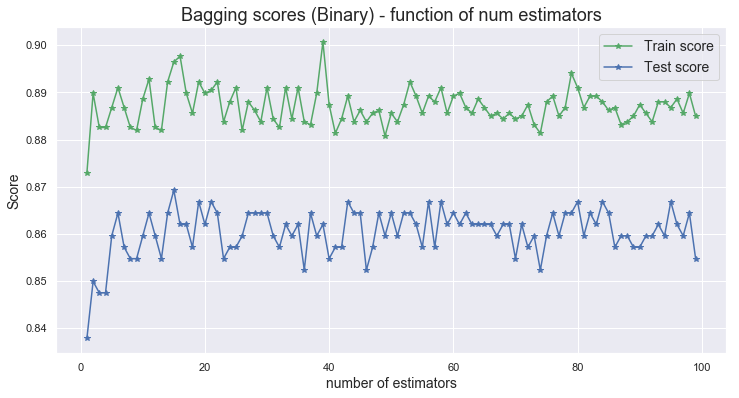

In [38]:
#Repeating the process for the binary response variable
num_trees = range(1,100)

scores = []
scores_test = []
for i in num_trees:
    bag = BaggingClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=i)
    bag.fit(X_train, y_train_bin)
    scores.append(bag.score(X_train, y_train_bin))
    scores_test.append(bag.score(X_test, y_test_bin))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(num_trees, scores, 'g*-', label = 'Train score')
ax.plot(num_trees, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('number of estimators', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('Bagging scores (Binary) - function of num estimators', size=18)

plt.show()

Among the Bagging Decision Trees for the binary response variable, `n_estimators=10` seems to be the best hyper parameter choice.

### Boosting decision tree

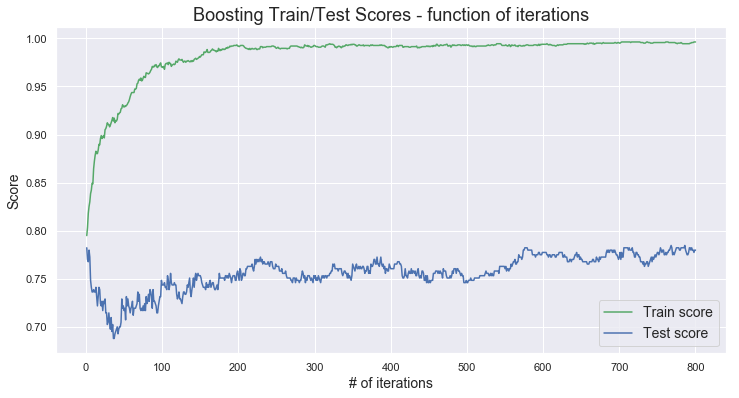

In [30]:
boo = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=800, learning_rate=0.5)
boo.fit(X_train, y_train_multi)

scores = list(boo.staged_score(X_train, y_train_multi))
scores_test = list(boo.staged_score(X_test, y_test_multi))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(range(1,801), scores, 'g-', label = 'Train score')
ax.plot(range(1,801), scores_test, 'b-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('# of iterations', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('Boosting Train/Test Scores - function of iterations', size=18)

plt.show()

In [32]:
scores_test.index(max(scores_test))

767

The boosting procedure with 8 iterations seems to be our best choice of hyper parameters to predict the multi category response variable.

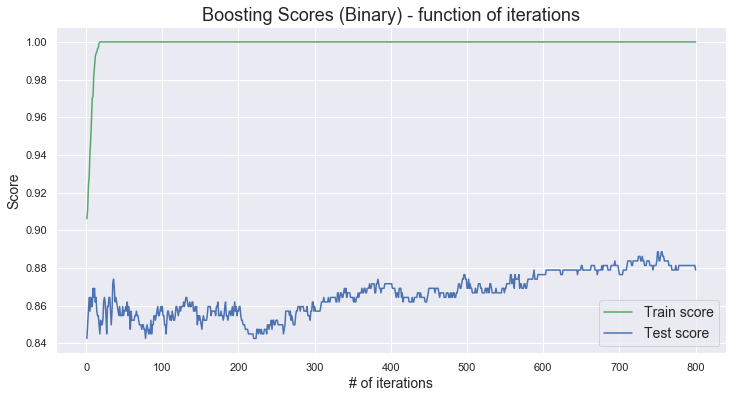

In [23]:
#Repeating the process for the binary response variable
boo = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=800, learning_rate=0.5)
boo.fit(X_train, y_train_bin)

scores = list(boo.staged_score(X_train, y_train_bin))
scores_test = list(boo.staged_score(X_test, y_test_bin))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(range(1,801), scores, 'g-', label = 'Train score')
ax.plot(range(1,801), scores_test, 'b-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('# of iterations', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('Boosting Scores (Binary) - function of iterations', size=18)

plt.show()

In [24]:
scores_test.index(max(scores_test))

749

The boosting procedure with 595 iterations seems to be our best choice of hyper parameters to predict the binary response variable.

### Random Forest

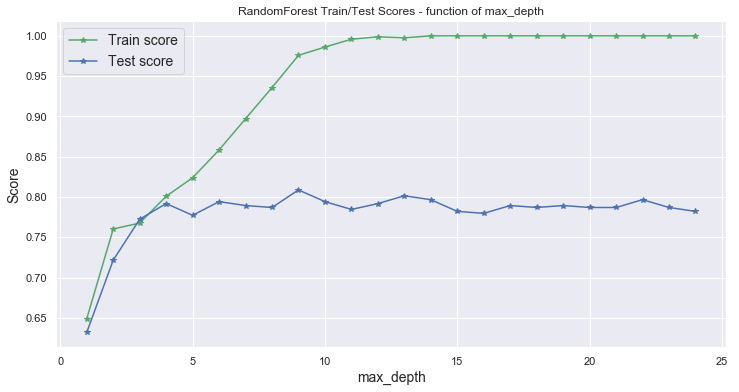

In [28]:
depths = range(1,25)

scores = []
scores_test = []
for i in depths:
    rfc = RandomForestClassifier(n_estimators=50, max_depth=i)
    rfc.fit(X_train, y_train_multi)
    #scores.append(np.mean(cross_val_score(rfc, X_train, y_train_multi, cv=5)))
    scores.append(rfc.score(X_train, y_train_multi))
    scores_test.append(rfc.score(X_test, y_test_multi))

fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(depths, scores, 'g*-', label = 'Train score')
ax.plot(depths, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('max_depth', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('RandomForest Train/Test Scores - function of max_depth')

plt.show()

Among the Random Forest models for the multi category response variable, `max_depth=4` appears to be the optimal parameter.

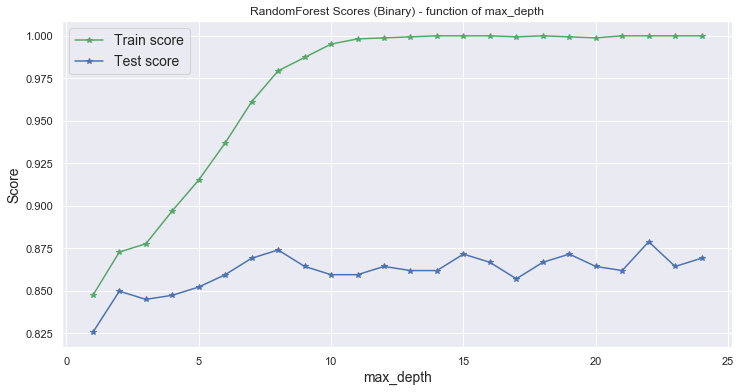

In [27]:
#Repeating the process for the binary response variable
depths = range(1,25)

scores = []
scores_test = []
for i in depths:
    rfc = RandomForestClassifier(n_estimators=50, max_depth=i)
    rfc.fit(X_train, y_train_bin)
    #scores.append(np.mean(cross_val_score(rfc, X_train, y_train_bin, cv=5)))
    scores.append(rfc.score(X_train, y_train_bin))
    scores_test.append(rfc.score(X_test, y_test_bin))
    
fig, ax = plt.subplots(1,1, figsize=(12, 6))

ax.plot(depths, scores, 'g*-', label = 'Train score')
ax.plot(depths, scores_test, 'b*-', label = 'Test score')
ax.legend(fontsize=14)
ax.set_xlabel('max_depth', size=14)
ax.set_ylabel('Score', size=14)
ax.set_title('RandomForest Scores (Binary) - function of max_depth')

plt.show()

Among the Random Forest models for the binary response variable, `max_depth=8` appears to be the optimal parameter.